This notebook is for exploratory analysis of COVID-19 Radiography database from Kaggle : https://www.kaggle.com/tawsifurrahman/covid19-radiography-datab
ase


In [ ]:
import os
import random
from collections import defaultdict
from glob import glob
from math import pi
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from joblib import Parallel, delayed
from skimage.feature import graycomatrix, graycoprops
from tqdm.auto import tqdm

# CHEMINS ET CHARGEMENT DES DONNEES

## CHEMINS

In [ ]:
# @title VARIABLES DE SESSION
# @markdown
DATA_ROOT = "../data"  # @param {type: "string"}
# @markdown ---

In [ ]:
DATA_ROOT = Path(DATA_ROOT)
RAW_DATA = DATA_ROOT / "01_raw/COVID-19_Radiography_Dataset"
REPS = ["COVID", "Lung_Opacity", "Viral Pneumonia", "Normal"]

In [ ]:
# TODO (Done): taille des images, canaux, nombre,
# TODO (All): Tester l'environnement de travail
# TODO (Yeyecodes): Appliquer les masques et refaire haraclick, moyenne des pixels,
# TODO (Yeyecodes & CedrickArmel): interprétation Haralickpuis
# TODO (TaxelleT & CedrickArmel): calculer l'aire des poumons. Gauche versus droite
# TODO (CedrickArmel): Explorer si la maladie ne concerne qu'une seule partie du poumon.
# TODO (CedrickArmel): équilibrer les classes, normaliser , rétirer les outlines, mettre les masques,
# TODO (TaxelleT & CedrickArmel): Appliquer pour mettre en évidence les files, cables

# TODO: data augmentation pour gérer les conditions de prise de vue
# TODO: Appliquer pour mettre en évidence les files, cables

## CHARGEMENT DES DONNES

In [ ]:
metadata = pd.concat(
    [pd.read_excel(file) for file in glob(os.path.join(RAW_DATA, "*.metadata.xlsx"))]
)
metadata.columns = ["file_name", "format", "size", "url"]

In [ ]:
images = defaultdict()
masks: defaultdict = defaultdict()

In [ ]:
print(
    f"Unique files format in `{RAW_DATA}` subfolders :",
    set([Path(f).suffix for f in glob(str(RAW_DATA / "**/**/*"))]),
)

Unique files format in `../data/01_raw/COVID-19_Radiography_Dataset` subfolders : {'.png'}


> All files in the subfolders of `RAW_DATA` are PNG images.

In [ ]:
for rep in REPS:
    images[rep.lower().replace(" ", "_")] = [
        cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        for f in glob(str(RAW_DATA / rep / "images/*.png"))
    ]

    masks[rep.lower().replace(" ", "_")] = [
        cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        for f in glob(str(RAW_DATA / rep / "masks/*.png"))
    ]

Par exemple pour accéder aux images de la catégorie COVID, faire:
```python
covid_images: list[np.ndarray] = images["covid"]
```
`cv2.IMREAD_GRAYSCALE` pour charger les images en niveaux de gris (une seule bande).

# EXPLORATION DES DONNEES

## EDA

### Analyse des métadonnées

In [ ]:
for key, imgs in images.items():
    images_size = set([img.shape for img in imgs])
    mask_size = set([img.shape for img in masks[key]])
    print(f"{key.replace('_', ' ').upper()}")
    print("\tNombre d'images : ", len(imgs))
    print("\tNombre de masques : ", len(masks[key]))
    print("\tTailles d'images : ", list(images_size))
    print("\tTailles de masques : ", list(mask_size), "\n")

COVID
	Nombre d'images :  3616
	Nombre de masques :  3616
	Tailles d'images :  [(299, 299)]
	Tailles de masques :  [(256, 256)] 

LUNG OPACITY
	Nombre d'images :  6012
	Nombre de masques :  6012
	Tailles d'images :  [(299, 299)]
	Tailles de masques :  [(256, 256)] 

VIRAL PNEUMONIA
	Nombre d'images :  1345
	Nombre de masques :  1345
	Tailles d'images :  [(299, 299)]
	Tailles de masques :  [(256, 256)] 

NORMAL
	Nombre d'images :  10192
	Nombre de masques :  10192
	Tailles d'images :  [(299, 299)]
	Tailles de masques :  [(256, 256)] 



In [ ]:
metadata.head()

,file_name,format,size,url
0,Lung_Opacity-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,Lung_Opacity-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
2,Lung_Opacity-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
3,Lung_Opacity-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
4,Lung_Opacity-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [ ]:
metadata["health_status"] = metadata.file_name.apply(lambda x: x.split("-")[0])
metadata["is_healthy"] = metadata.file_name.apply(
    lambda x: "Sain" if "normal" in x.lower() else "Malade"
)

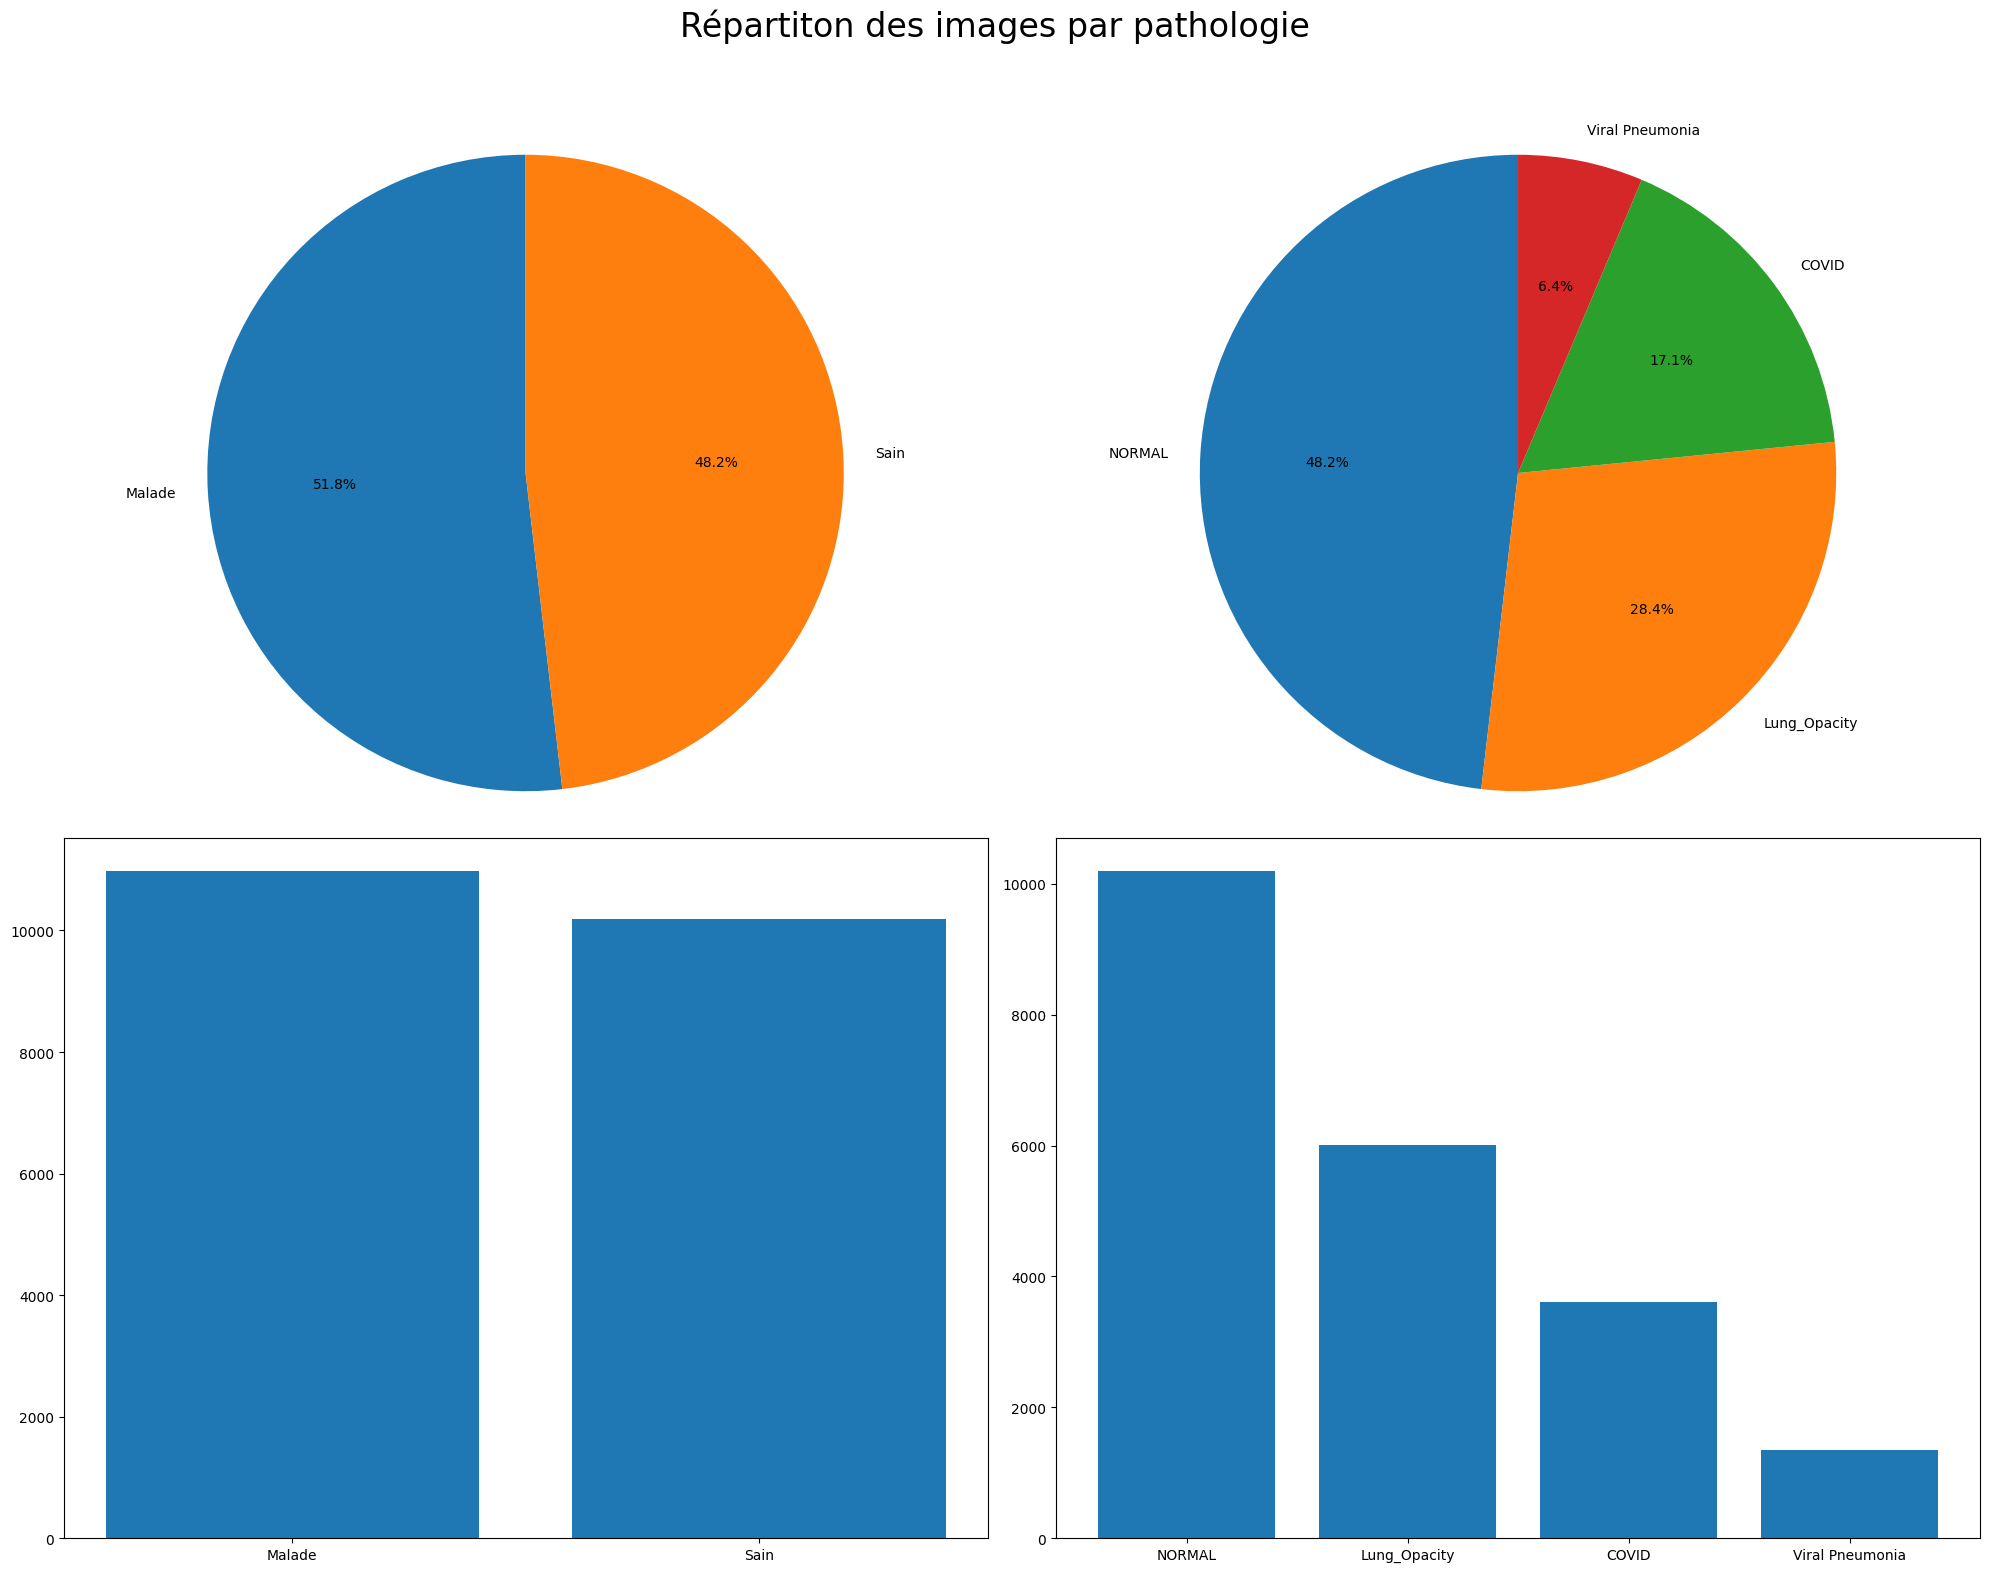

In [ ]:
hs_counts = metadata.health_status.value_counts()
ih_counts = metadata.is_healthy.value_counts()

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()
axes[0].pie(ih_counts.values, labels=ih_counts.index, autopct="%1.1f%%", startangle=90)
axes[0].axis("equal")
axes[2].bar(height=ih_counts.values, x=ih_counts.index)

axes[1].pie(hs_counts.values, labels=hs_counts.index, autopct="%1.1f%%", startangle=90)
axes[1].axis("equal")
axes[3].bar(height=hs_counts.values, x=hs_counts.index)
fig.suptitle("Répartiton des images par pathologie", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## ANALYSE TEXTURALES DES IMAGES

La texture d’une image désigne la structure spatiale de l’intensité de luminosité des pixels, qui se répète périodiquement sur l’ensemble de l’image ou sur certaines de ses parties, et qui caractérise la nature de l’image.

Analyser la texture d'une image consiste à essayer de découvrir les motifs qui se repètent et de les extraire sous forme d'une valeur numérique. Répéter cet exercie évolutif à l'échelle de tout notre jeu de données peut nous permettre d'identifier les motifs caractéristiques de chaque catégorie d'images et des biais potentiels.

Plusieurs méthode existent pour analyser la texture d'une image, mais pour cette analyse nous faisons le choix arbitraire d'appliquer une approche qui se base sur la matrice de co-occurence des niveaux de gris ou *Gray-Level Cooccurence Matrix (GLCM)*\[[1](https://colab.research.google.com/drive/1Lntxtu_EDeoG5Rv8eux6W-FDcxn8oZFv#scrollTo=CriYcJt1oZTx&line=5&uniqifier=1)\].

Pour une image avec 256 niveaux de gris, la matrice de co-occurence GLCM est de taille 256 x 256.

Chaque cellule de la matrice de co-occurence GLCM de coordonées $(x, y)$ représente le nombre de fois le niveau de gris $x$ a été observé sous une relation $d$ avec le niveau $y$ dans cette image.

La GLCM est un opérateur statistique et probabiliste qui permet d'extraire des statistiques d'une image qui peuvent représenter sa texture. Ces statistiques dites de Haralick sont: moyenne, variance, entropie, contraste, dissimilarité, homogeneité, ASM, énergie et corrélation.


## CALCUL DES CARACTERISTIQUES DE HARALICK

In [ ]:
def single_image_haralick(
    img: np.array, features: list, distances: list[int], angles: np.array
) -> dict[str, np.array]:
    """Computes a set of Haralick features for a single image."""
    glcm = graycomatrix(
        img, distances=distances, angles=angles, symmetric=True, normed=True
    )  # calcul de la GLCM
    result = {}
    for ft in features:
        props = graycoprops(glcm, prop=ft)  # Calcul des statistiques de Haralick
        result[ft] = props
    return result

Dans la cellule ci-dessus, les arguments `distances` (distance en pixels entre $x$ et $y$) et `angles` (direction en radians de $y$ par rapport à $x$), de la fonction `graycomatrix` de calcul de la GLCM, constituent la relation $d$ entre $x$ et $y$.

A partir de la GLCM, `graycoprops` calcule successivement les caractéristiques de Haralick suivantes:

*   **Moyenne (mean)** : $\sum_{i=0}^{levels-1} i*P_{i}$
*   **Ecart-type (std)** : $\sqrt{variance} = \sqrt{\sum_{i=0}^{levels-1} P_{i}*(i-mean)^2}$
*   **Entropie (entropy)** : $\sum_{i,j=0}^{levels-1} -P_{i,j}*log(P_{i,j})$
*   **Contraste (contrast)**: $\sum_{i,j=0}^{levels-1} P_{i,j}(i-j)^2$
*   **Homogénéité (homogeneity)** : $\sum_{i,j=0}^{levels-1}\frac{P_{i,j}}{1+(i-j)^2}$
*   **Energie (energy)** : $\sqrt{ASM} = \sqrt{\sum_{i,j=0}^{levels-1}P_{i,j}}$
*   **Corrélation (correlation)** : $\sum_{i,j=0}^{levels-1} P_{i,j}\left[\frac{(i-\mu_i)
(j-\mu_j)}{\sqrt{(\sigma_i^2)(\sigma_j^2)}}\right]$

Mais il est également de calculer ces caractéristiques que nous laissons délibérément de côté car elles apportent des informations similaires à celles calculés:
*   **Dissimilarité (dissimilarity)** : $\sum_{i,j=0}^{levels-1}P_{i,j}|i-j|$ similaire au contraste.
*   **ASM**, voir énergie
*   **Variance**, voir écart-type.


In [ ]:
def compute_haralick_parallel(
    images: list[np.ndarray],
    features: list,
    distances: list[int],
    angles: np.array,
    n_jobs: int = -1,
    verbose=1,
) -> list[dict]:
    """Computes a set of Haralick features for a set of images in parallel using joblib."""
    results = Parallel(n_jobs=n_jobs, verbose=verbose)(
        delayed(single_image_haralick)(img, features, distances, angles)
        for img in images
    )
    return results

In [ ]:
DMAX = 29
HARALICK_FEATURES = [
    "mean",
    "std",
    "entropy",
    "contrast",
    "homogeneity",
    "energy",
    "correlation",
]
ANGLES = (np.pi / 4) * np.arange(0, 4)  # angles in rad from 0 to pi
DIRECTIONS = {"horizontal": 0, "diagonal1": 1, "vertical": 2, "diagonal2": 3}

In [ ]:
haralick_features = defaultdict(lambda: defaultdict(lambda: np.empty((DMAX, 0))))

```python
for rep, pool in tqdm(images.items()):
  results = compute_haralick_parallel(pool, HARALICK_FEATURES, range(DMAX), ANGLES)
  for r in results:
    for ft in HARALICK_FEATURES:
      haralick_features[ft][rep] = np.concat([haralick_features[ft][rep], r[ft]], axis=1)
```

```python
for rep in images.keys():
  for ft in HARALICK_FEATURES:
         np.save(file=PROJECT_ROOT/f"data/00_dumps/haralick_features_{ft}_{rep}.npy", arr=haralick_features[ft][rep], allow_pickle=False)
```

Ci-dessous nous important directement les données précalculées (voir `Markdown`ci-dessus) de textures depuis le dossier Drive du projet.

In [ ]:
for rep in images.keys():
    for ft in HARALICK_FEATURES:
        haralick_features[ft][rep] = np.load(
            DATA_ROOT / f"00_dumps/haralick_features_{ft}_{rep}.npy"
        )

## VISUALIZATION ET ANALYSE

### VISUALIZATION

In [ ]:
def display_haralick(
    d: str,
    directions: dict[str, int],
    haralick_features: dict[str, dict],
    ncols: int = 2,
):
    nrows = np.ceil(len(haralick_features) / ncols).astype(int)
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows * 4))
    axes = axes.flatten()
    for i, ft in enumerate(haralick_features):
        for rep in haralick_features[ft].keys():
            axes[i].plot(
                np.mean(haralick_features[ft][rep][:, directions[d] :: 4], axis=1),
                label=f"{rep.upper()}",
            )
        axes[i].set_title(ft.capitalize())
        # axes[i].legend(title="Health Status")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        title="Health Status",
        loc="center right",
        bbox_to_anchor=(0.98, 0.3),
    )
    fig.suptitle(
        f"Caractéristique de Haralick selon la direction {d.capitalize() if 'diagonal' not in d else 'Diagonal'} - {directions[d] * 45}°",
        fontsize=16,
    )
    fig.supxlabel("Distance entre $x$ et $y$", fontsize=14)
    fig.supylabel("Valeur des caractéristiques", fontsize=14, x=0)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.tight_layout()
    plt.show()

In [ ]:
def boxplot_all_haralick(haralick_features: dict[str, dict[str, np.ndarray]]) -> None:
    """Plots the computed Haralick's features box-plots.

    Args:
        haralick_features (dict[str, dict[str, np.ndarray]]): Haralick's features for all images.
    """
    features = list(haralick_features.keys())
    categories = list(next(iter(haralick_features.values())).keys())

    data_list = []
    for ft in features:
        for rep in categories:
            values = np.mean(haralick_features[ft][rep], axis=0)
            for v in values:
                data_list.append(
                    {"Feature": ft.capitalize(), "Category": rep.upper(), "Value": v}
                )

    df_plot = pd.DataFrame(data_list)

    plt.figure(figsize=(18, 6))
    sns.boxplot(x="Feature", y="Value", hue="Category", data=df_plot)
    plt.title("Distribution des features Haralick par catégorie")
    plt.ylabel("Valeur moyenne de la feature")
    plt.xlabel("Feature")
    plt.xticks(rotation=45)
    plt.legend(title="Catégorie")
    plt.tight_layout()
    plt.show()

In [ ]:
def heatmap_haralick_all(haralick_features: dict[str, dict[str, np.ndarray]]) -> None:
    """Plots the computed Haralick's features correlation heatmap.

    Args:
        haralick_features (dict[str, dict[str, np.ndarray]]): Haralick's features for all images.
    """
    for rep in next(iter(haralick_features.values())).keys():
        df = pd.DataFrame(
            {
                ft: np.mean(haralick_features[ft][rep], axis=0)
                for ft in haralick_features
            }
        )
        corr = df.corr()
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f", square=True
        )
        plt.title(
            f"Corrélation entre features Haralick – {' '.join(rep.split('_')).upper()}"
        )
        plt.tight_layout()
        plt.show()

In [ ]:
def radar_all_haralick(haralick_features: dict[str, dict[str, np.ndarray]]) -> None:
    """Plots the computed Haralick's features radar.

    Args:
        haralick_features (dict[str, dict[str, np.ndarray]]): Haralick's features for all images.
    """
    features = list(haralick_features.keys())
    reps = haralick_features[features[0]].keys()

    N = len(features)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    for rep in reps:
        values = [np.mean(haralick_features[ft][rep]) for ft in features]
        values += values[:1]
        ax.plot(angles, values, linewidth=2, label=" ".join(rep.split("_")).upper())
        ax.fill(angles, values, alpha=0.15)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=11)
    ax.set_title("Radar chart – Signatures des textures Haralick", fontsize=11)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.show()

#### Avant normalisation des images

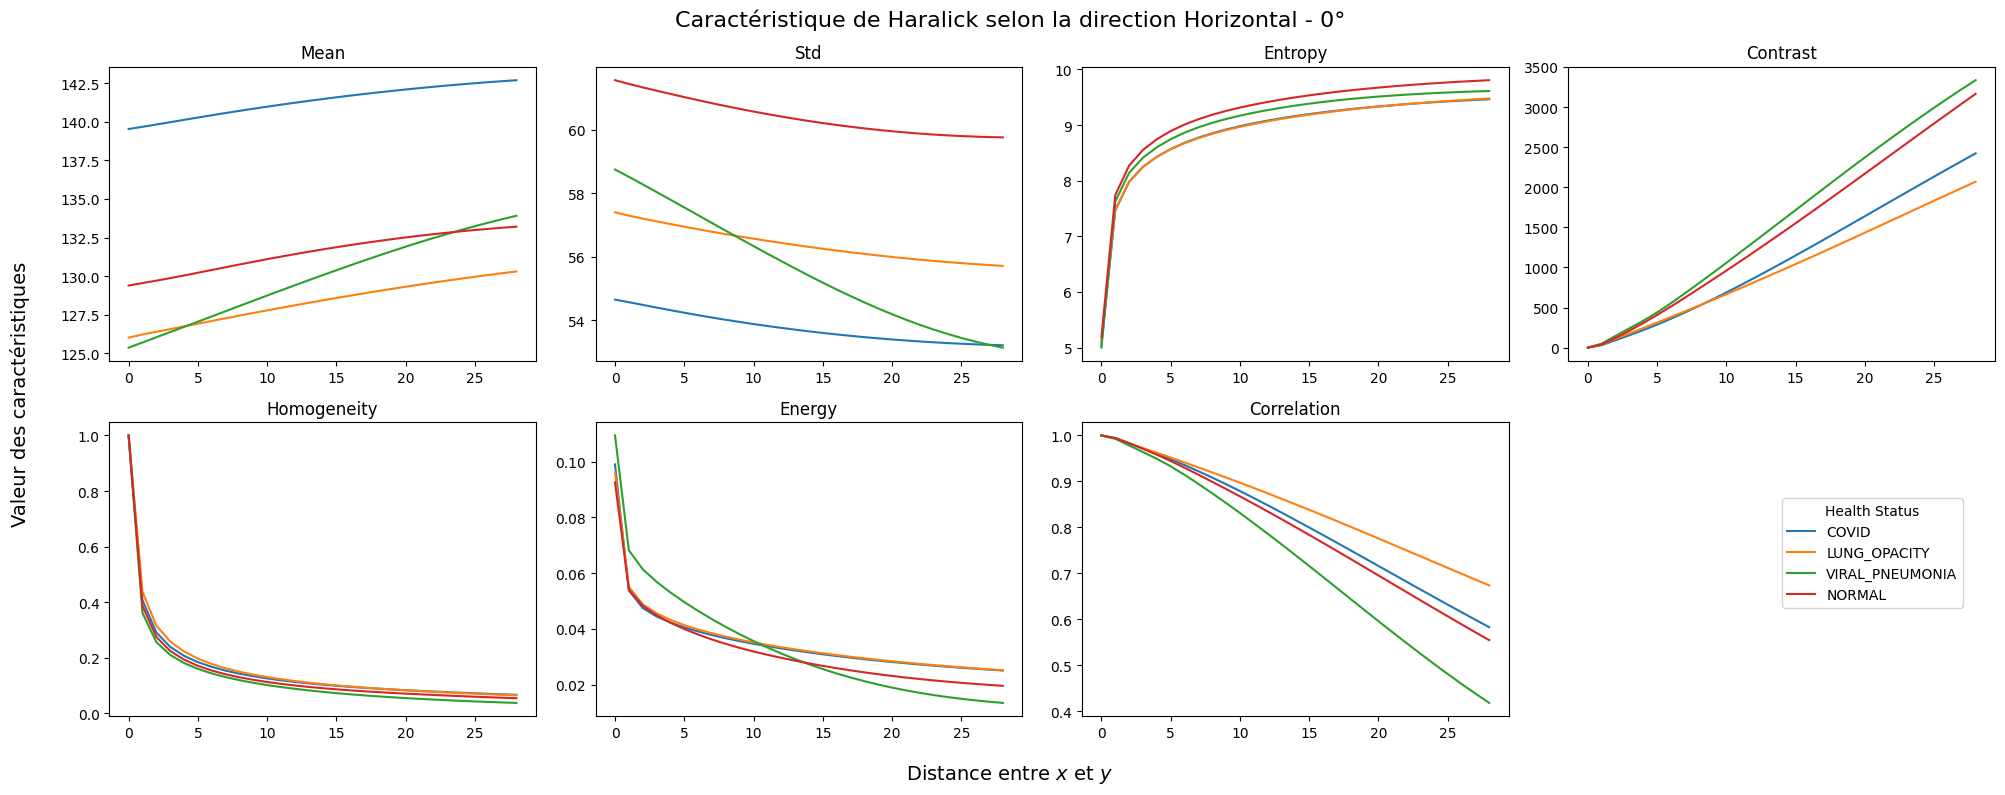

In [ ]:
display_haralick(
    d="horizontal", directions=DIRECTIONS, haralick_features=haralick_features, ncols=4
)

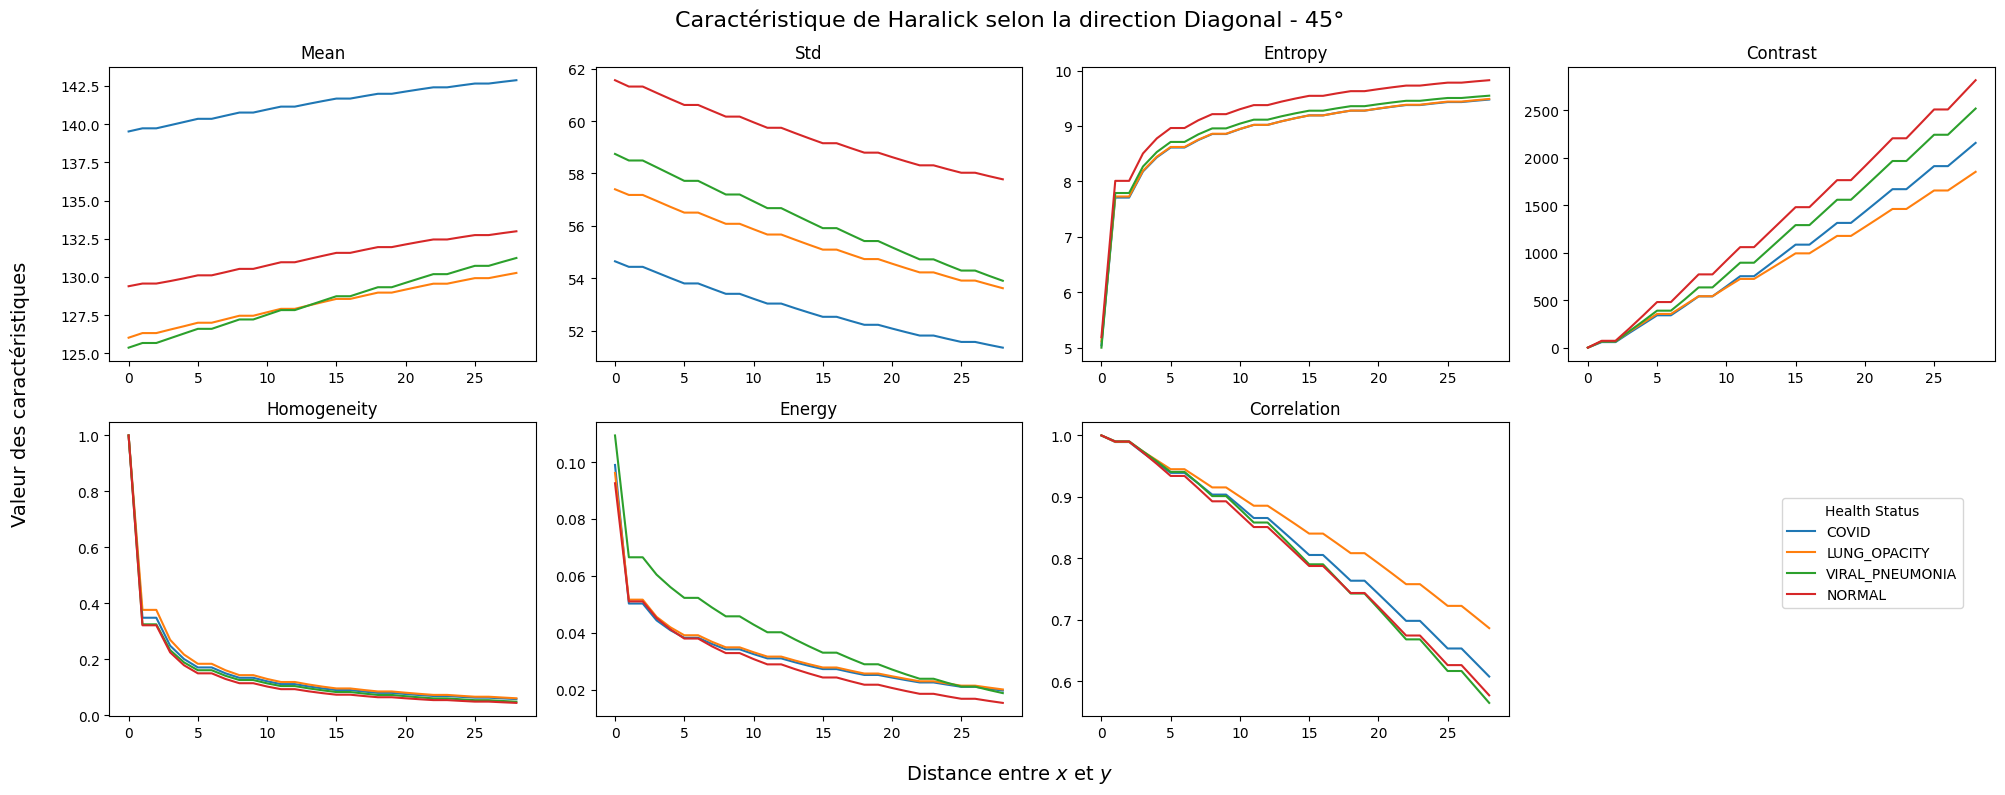

In [ ]:
display_haralick(
    d="diagonal1", directions=DIRECTIONS, haralick_features=haralick_features, ncols=4
)

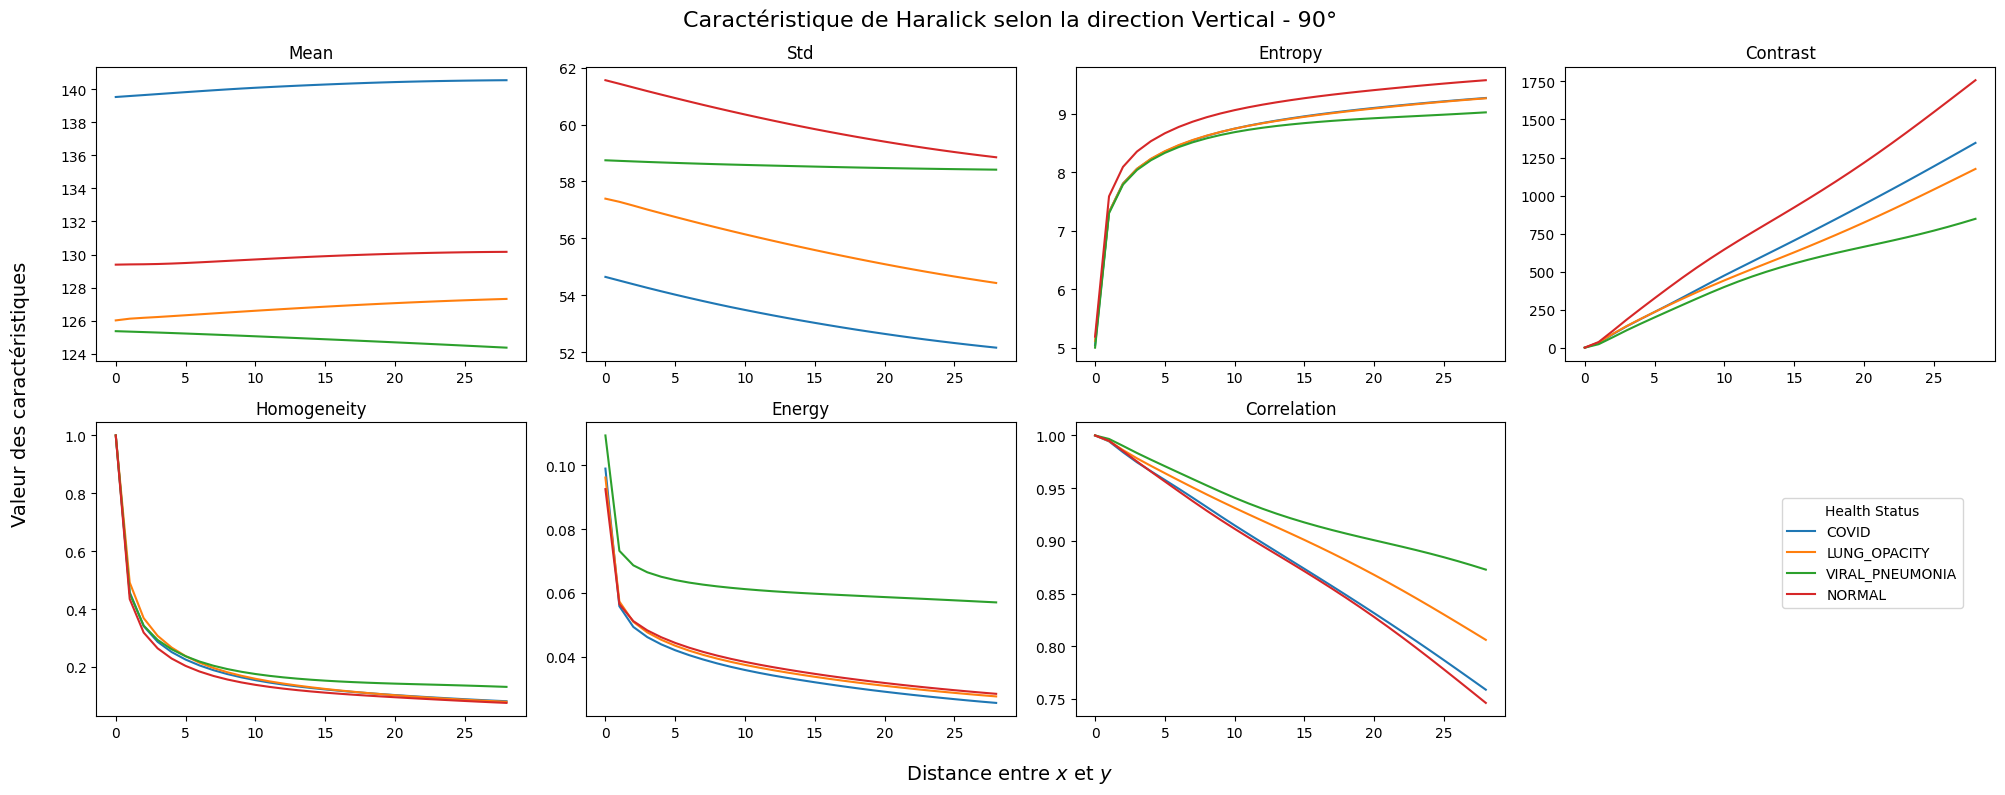

In [ ]:
display_haralick(
    d="vertical", directions=DIRECTIONS, haralick_features=haralick_features, ncols=4
)

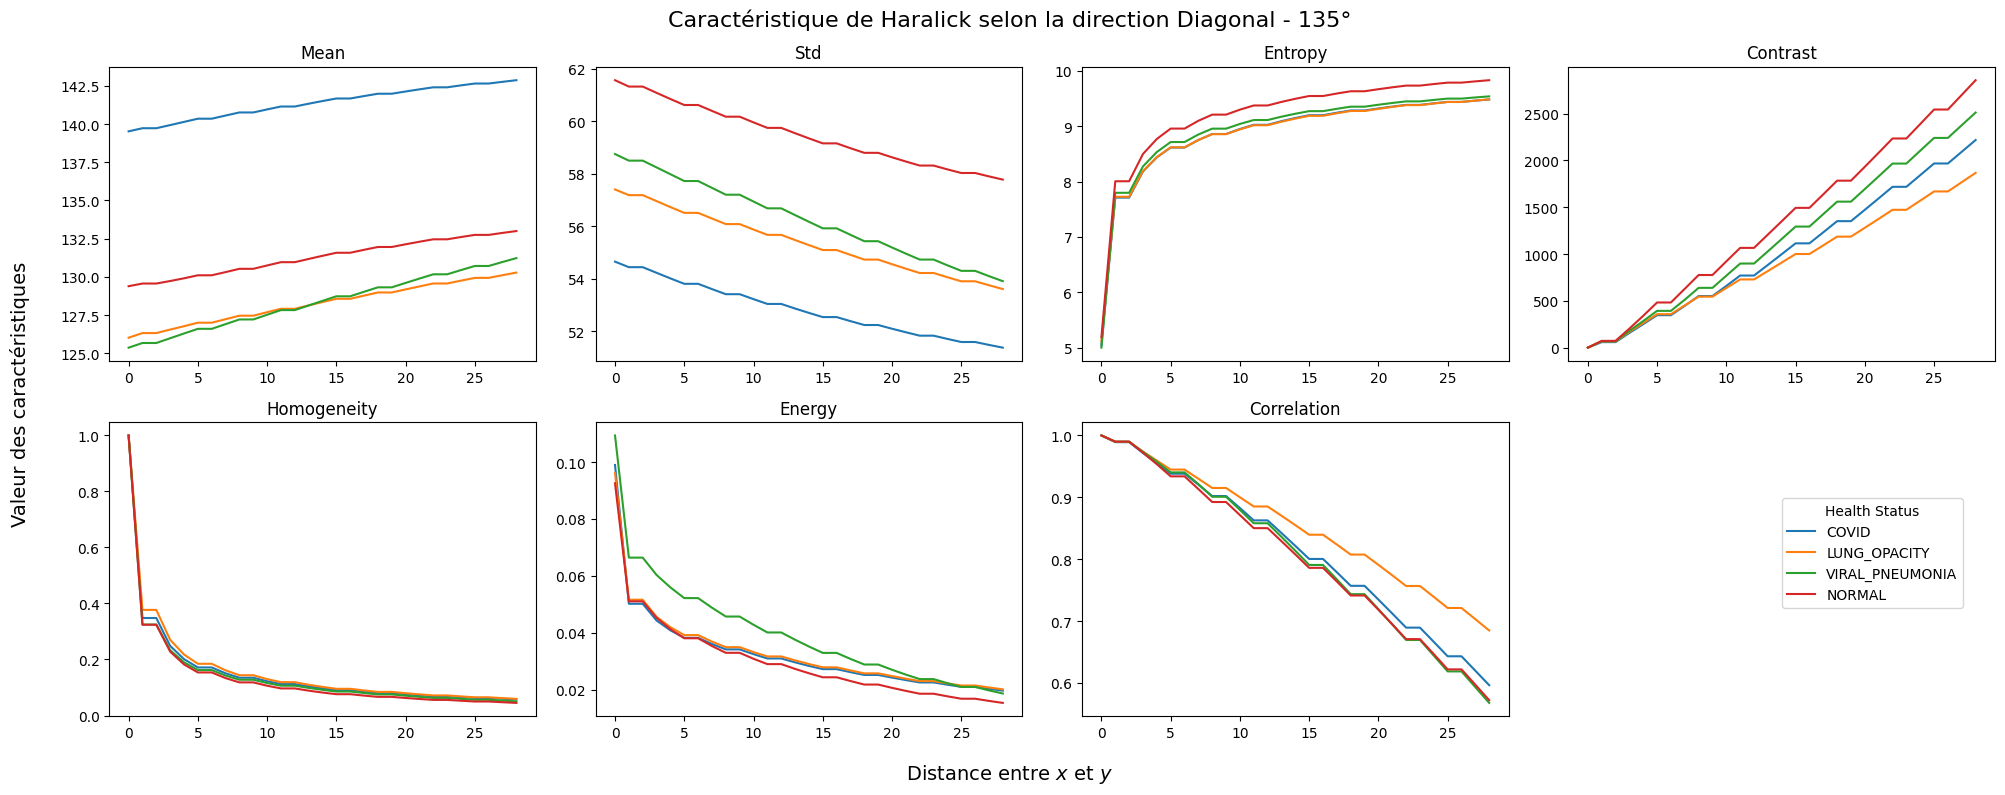

In [ ]:
display_haralick(
    d="diagonal2", directions=DIRECTIONS, haralick_features=haralick_features, ncols=4
)

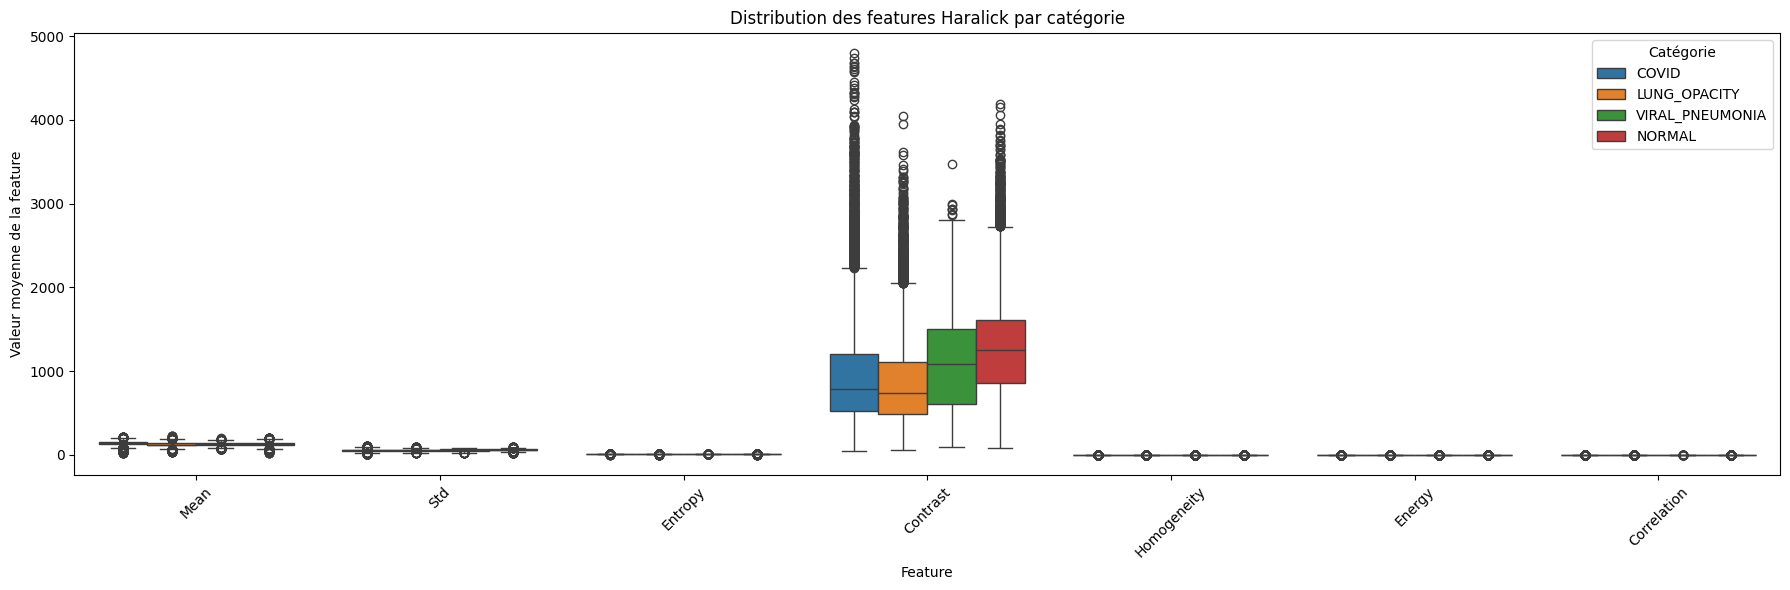

In [ ]:
boxplot_all_haralick(haralick_features)

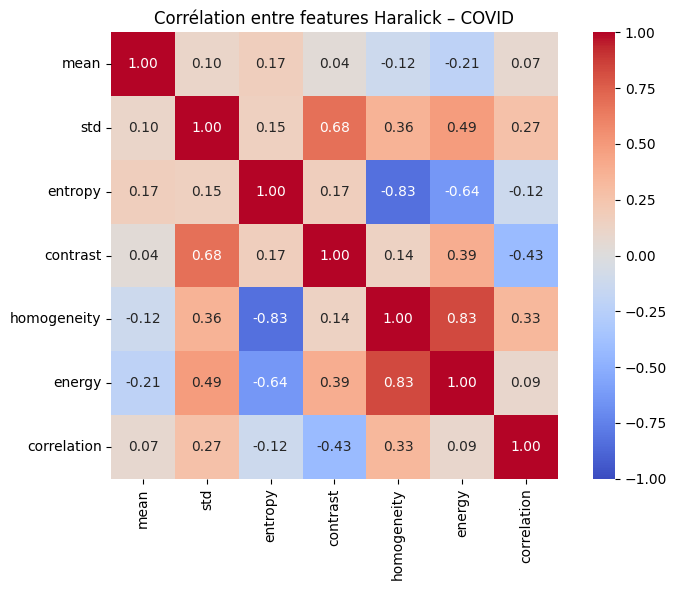

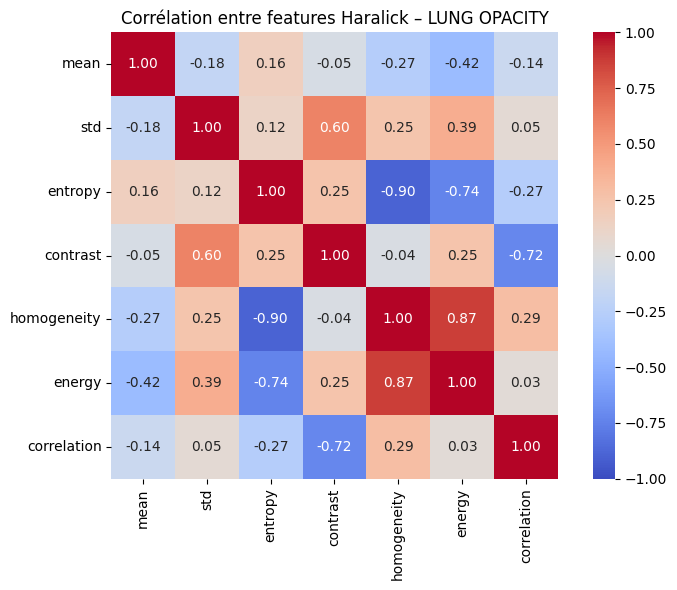

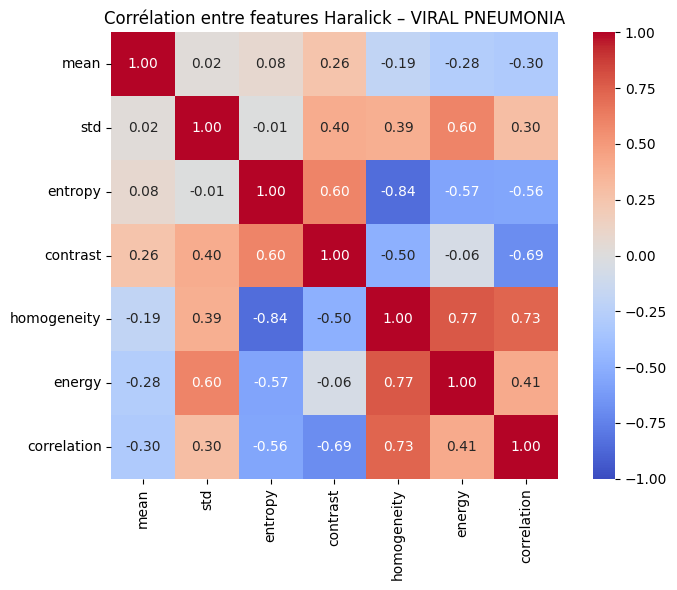

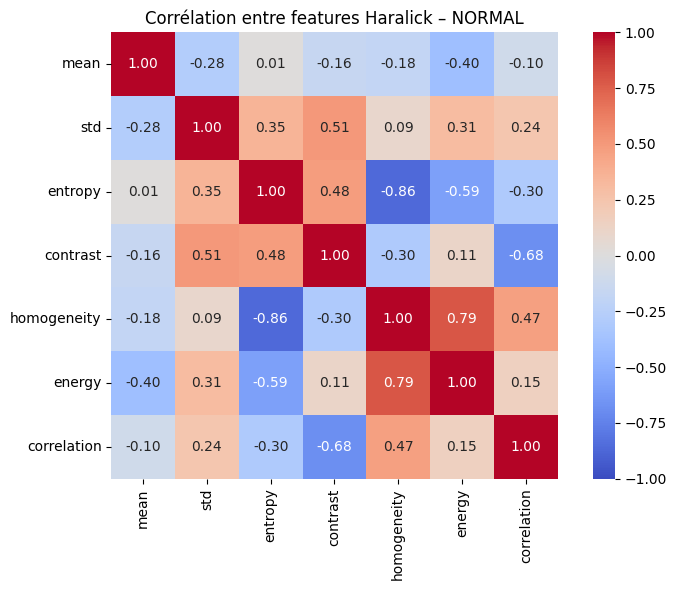

In [ ]:
heatmap_haralick_all(haralick_features)

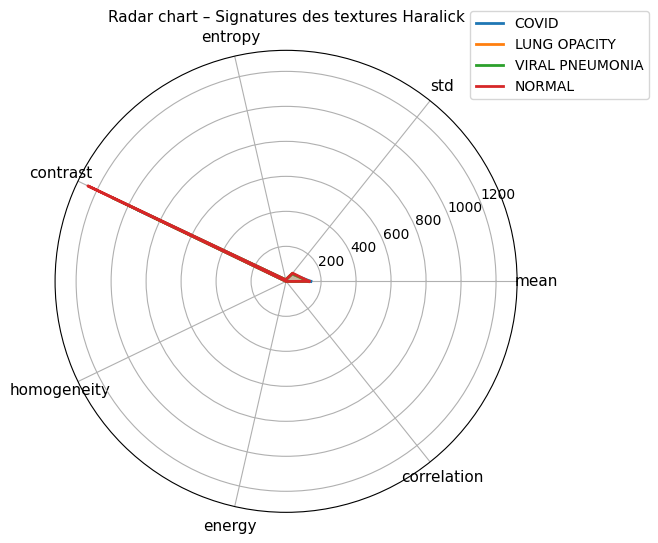

In [ ]:
radar_all_haralick(haralick_features)

#### Après normalisation des images

### ANALYSES ET INTERPRETATION
#### Avant normalisation des images
1. **Textures et structure spatiale**

On observe de grandes différences au niveau des intensités moyennes des pixels des images. Cela pourrait biaiser l'entrapinement du modèle. Ainsi, il faudrait obligatoirement normaliser/standardiser les données pour élimininer ou du moins atténuer ce biais.

Une autre source de biais apparente se situe au niveau du contraste qui semble être un élément discriminant entre les catégorie de pathologie. Il nous faut donc appliquer un prétraitement avec pour objectif d'atténuer ce biais à défaut de l'éliminer.

Pour ce qui concerne les caractériques de second ordre (entropie, homogénéité, énergie, contraste et correlation), on peut observer deux zones:

- **La première zone (0 à 3 pixels de distance)** caratérisée par une corrélation maximale malgré l'augementation très rapide complexité ou d'imprévisibilité des textures. Cela s'apparente à une sorte de désordre structuré: les pixels sont différents mais conservent une relation linéraire forte

 les images des différentes pathologies ont un comportement similaires pour des pixels proches (de 0 à 3 pixels de distance) et tendent à avoir des comportement différents à mesures que la distance entre les pixels considérés augemente.

2. **Box-Plot**

Features spécifiques :

Les features Mean, Std, Entropy, Homogeneity, Energy, Correlation présentent des valeurs relativement très faibles. Leurs distributions sont quasi identiques. Elles apportent très peu d'informations discriminantes.

Contrast :
La classe Normal et Viral ont les valeurs les plus élevées. On note une dispersion importante et beaucoup de outliers ce qui implique une texture très variable. On peut donc en deduire que le contrast est une feature fortement discrimante et qu'elle capte bien les différences de texture pulmonaire.
Il en ressort donc que les pathologies (COVID, Pneumonia, Lung Opacity) présentent des textures plus homogènes tandisque les pathologies viral et normal présentent des textures variables (constrastées)

3. **Correlation**

D’après la matrice de correlation de la pathologie COVID, on note une forte correlation entre les features energy et homogeneity (+0.83%). Cependant on note une forte correlation negative entre les features entropy et homogeneity(-0.83%).
La matrice de correlation de la pathologie LUNG_OPACITY, on note une forte correlation entre les features energy et homogeneity (+0.87%). Cependant on note une forte correlation negative entre les features entropy et homogeneity(-0.90%).
La matrice de correlation de la pathologie VIRAL_PNEUMONIA, on note une forte correlation entre les features energy et homogeneity (+0.77%). Cependant on note une forte correlation negative entre les features entropy et homogeneity(-0.84%).
La matrice de correlation de la pathologie NORMAL, on note une forte correlation entre les features energy et homogeneity (+0.79%). Cependant on note une forte correlation negative entre les features entropy et homogeneity(-0.86%).

De tout ce qui précède, il ressort que les matrices de corrélation montrent une forte opposition entre entropy et homogénéité dans les images, traduisant une texture pulmonaire désorganisée. Certaines caractéristiques comme l’énergie et l’homogénéité apparaissent redondantes, tandis que le contraste et l’entropie offrent un fort pouvoir discriminant

4. **Radar**

On observe que les features std, mean, correlation, energy, homogeneity, entropy existent mais sont compressées. Cependant, le contrast capte fortement les anomalies pulmonaires. On peut donc déduire que la feature contrast est la feature la plus discriminante brute.

5. **Conclusion partielle**

#### Après normalisation des images
1. **Textures et structure spatiale**
2. **Box-Plot**
3. **Correlation**
4. **Radar**
5. **Conclusion partielle**

#### Conclusion sur les caractéristiques de Haralick

# REFRENCES



1.   Haralick, RM.; Shanmugam, K., “Textural features for image classification” IEEE Transactions on systems, man, and cybernetics 6 (1973): 610-621. [DOI:10.1109/TSMC.1973.4309314](https://doi.org/10.1109/TSMC.1973.4309314)
2.   

